### Test case LVV-T129: Verify implementation of Provide Calibrated Photometry

Verify that the DMS provides photometry calibrated in AB mags and fluxes (in nJy) for all measured objects and sources. Must be tested for both DRP and AP products.

#### Discussion

This test will be executed on the Rubin Science Platform Notebook Aspect using public-facing Data Preview 1 (DP1) tables ingested into the Qserv database, and made available via TAP query.

Initialize the TAP service, and print its endpoint to the screen.

In [1]:
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from lsst.rsp import get_tap_service

service = get_tap_service("tap")

md(f'The service endpoint for TAP in this environment is:\n\n &#10145;&nbsp;&nbsp;   {service.baseurl}')

The service endpoint for TAP in this environment is:

 &#10145;&nbsp;&nbsp;   https://data-int.lsst.cloud/api/tap

#### Define functions to perform the tasks of extracting and checking the table columns

In [2]:
def get_flux_cols(schema):
    """Retrieve columns with expected units of flux.

    Parameters
    ----------
    schema : Astropy `Table`
        Table schema to be search.

    Returns
    -------
    fluxcol_list : `list`
        List of column names expected to contain flux values.
    """

    fluxcol_list = []

    # Remove columns that may contain the word "flux" in them, but that are not expected
    # to contain fluxes. These include flags and measurements derived from fluxes.
    for col in schema['column_name']:
        if ('Flux' in col) & ('flag' not in col) & ('deblend' not in col) &\
           ('area' not in col) & ('apCorr' not in col) & ('instFlux' not in col) &\
           ('Slope' not in col) & ('Chi2' not in col) & ('Ndata' not in col) &\
           ('Skew' not in col) & ('StetsonJ' not in col):
            fluxcol_list.append(col)

    return fluxcol_list

In [3]:
def assert_all_equal(list_to_check, value):
    """Use an assert to determine whether list items equal a given value.

    Parameters
    ----------
    list_to_check : `list`
        List of strings to check against a value.
    value : `str`
        String to check list items against.
    """

    try:
        assert all(x == value for x in list_to_check)
        print(f"All elements have units of {value}.")
    except:
        print('Assert failed')

In [4]:
def check_column_units(table, units_value):
    """Given an input table, check whether each of its columns
       has units of the specified type.

    Parameters
    ----------
    table : Astropy `Table`
        Data table to check.
    units_value : `str`
        String with the expected units to check against table columns.
    """

    units = []
    for col in table.columns:
        if table[col].unit is None:
            units.append(None)
        else:
            units.append(table[col].unit.name)

    # units = [table[col].unit.name for col in table.columns]
    try:
        assert all(x == units_value for x in units)
        print(f"All elements have units of {units_value}.")
    except:
        failed_cols = np.where(np.array(units) != units_value)
        print('Assert failed. Failed columns:')
        print(np.array(table.colnames)[failed_cols])

#### Test on Object, Source, DiaObject, DiaSource, ForcedSource, and ForcedSourceOnDiaObject

Extract each of these tables in turn, retrieving a list of columns that are expected to contain flux values, and then confirm that those columns indeed contain fluxes with units of nanoJansky ("nJy").

In [5]:
tables_list = ['Object', 'Source', 'DiaObject', 'DiaSource',
               'ForcedSource', 'ForcedSourceOnDiaObject']

In [6]:
for table in tables_list:
    print(f"Checking {table} table...")
    tab_schema = service.search(f"SELECT column_name, datatype, description, unit \
                                FROM tap_schema.columns \
                                WHERE table_name = 'dp1.{table}'").to_table()
    fluxcol_list = get_flux_cols(tab_schema)
    # Some tables have coord_ra, coord_dec columns, and others have ra, dec.
    # Check which one it is before executing the query.
    if 'coord_ra' in tab_schema['column_name']:
        racol = 'coord_ra'
        deccol = 'coord_dec'
    else:
        racol = 'ra'
        deccol = 'dec'
    results = service.search(f"SELECT TOP 10 {','.join(fluxcol_list)} \
                             FROM dp1.{table} \
                             WHERE CONTAINS(POINT('ICRS', {racol}, {deccol}), \
                             CIRCLE('ICRS', 53.13, -28.10, 0.05)) = 1").to_table()
    check_column_units(results, 'nJy')
    print('\n')

Checking Object table...
All elements have units of nJy.


Checking Source table...
All elements have units of nJy.


Checking DiaObject table...
All elements have units of nJy.


Checking DiaSource table...
Assert failed. Failed columns:
['dipoleMeanFlux' 'dipoleMeanFluxErr']


Checking ForcedSource table...
All elements have units of nJy.


Checking ForcedSourceOnDiaObject table...
All elements have units of nJy.




The second line of the above output for each table confirms that all fluxes for the subset of columns extracted are in nanoJanskys for all tables except `DiaSource`. Thus the requirement is met for all table except `DiaSource`. We will examine that table's columns more below.


#### Extract a small amount of data from the Object table and check the fluxes

While it is claimed in each table that the fluxes have been calibrated to nJy, let us now check whether the tabulated values are in a reasonable range for astrophysical sources. 

In [7]:
results = service.search("SELECT coord_ra, coord_dec, \
                          g_psfFlux, r_cModelFlux \
                          FROM dp1.Object as obj \
                          WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), \
                          CIRCLE('ICRS', 53.13, -28.10, 0.05)) = 1").to_table()


In [8]:
results[0:10]

coord_ra,coord_dec,g_psfFlux,r_cModelFlux
deg,deg,nJy,nJy
float64,float64,float32,float32
53.091793161320396,-28.13316839453141,50.0253,83.3014
53.14210014588123,-28.133610530368884,227.008,257.453
53.13896302023838,-28.122574410933076,106.163,224.656
53.10397374879734,-28.128228974146708,64.0774,120.46
53.102170003066114,-28.126844665527475,42.8366,130.879
53.13957431767005,-28.12690377720079,288.52,695.961
53.091760825684496,-28.12734474860784,48.671,77.5648
53.11785338347242,-28.128822453925398,-11.7456,16.2318


#### Check the flux values

The following cell demonstrates that these fluxes can be converted to AB magnitudes using Astropy unit conversions.

In [9]:
psffluxes_njy = results['g_psfFlux']
print(psffluxes_njy.to(u.ABmag)[:10])

cmodelfluxes_njy = results['r_cModelFlux']
print(cmodelfluxes_njy.to(u.ABmag)[:10])

[27.152025 25.5099   26.33507  26.883238 27.320463 25.249561 27.181826
       nan       nan 24.744614] mag(AB)
[26.598373 25.373257 25.521206 26.197895 26.107828 24.29354  26.675838
 28.374084 27.603859 23.563354] mag(AB)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [10]:
# Assume the units are nJy, then convert to magnitudes to check whether the values are "reasonable":
psfmag = psffluxes_njy.to(u.ABmag)
cmodelmag = cmodelfluxes_njy.to(u.ABmag)

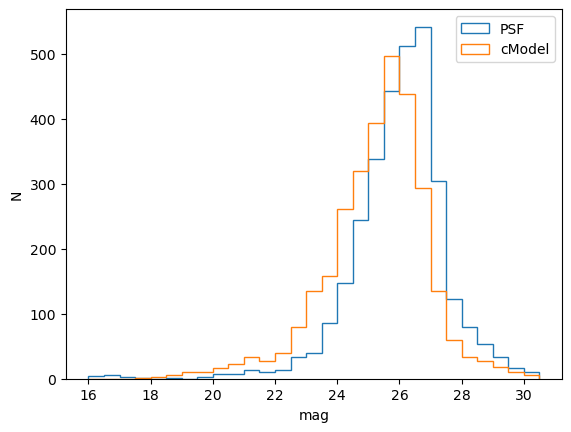

In [11]:
plt.hist(psfmag.value, bins=np.arange(16, 31, 0.5), histtype='step', label='PSF')
plt.hist(cmodelmag.value, bins=np.arange(16, 31, 0.5), histtype='step', label='cModel')
plt.xlabel('mag')
plt.ylabel('N')
plt.legend()
plt.show()

#### Check the columns from DiaSource that were flagged

This test unveiled the fact that the `dipoleMeanFlux` column (and its associated error) from `DiaSource` is listed incorrectly in the table schema. A ticket has been filed to fix this: [DM-51812: "DP1 dipole flux description inconsistencies"](https://rubinobs.atlassian.net/browse/DM-51812). The error is simply a mistake in moving the schema from its location in the Science Pipelines codebase to the DP1 repository.

To confirm this, check the columns to see whether their fluxes have reasonable values.


In [12]:
results = service.search("SELECT ra, dec, \
                          dipoleMeanFlux, dipoleMeanFluxErr \
                          FROM dp1.DiaSource \
                          WHERE CONTAINS(POINT('ICRS', ra, dec), \
                          CIRCLE('ICRS', 53.13, -28.10, 0.05)) = 1").to_table()


In [13]:
dipolefluxes_njy = results['dipoleMeanFlux'].compressed().value*u.nJy
print(dipolefluxes_njy.to(u.ABmag)[:10])

dipoleflux_witherrs_njy = dipolefluxes_njy+results['dipoleMeanFluxErr'].compressed().value*u.nJy
print(dipoleflux_witherrs_njy.to(u.ABmag)[:10])

[20.15772091 20.15496763 20.13760086 20.14581369 20.14718157 20.15874341
 20.19835079 20.19470039 20.16165547 20.16175555] mag(AB)
[20.06946223 20.10824542 20.12006914 20.12119728 20.12763919 20.09342048
 20.17637352 20.09049459 20.08200071 20.064296  ] mag(AB)


In [14]:
# Assume the units are nJy, then convert to magnitudes to check whether the values are "reasonable":
dipolemag = dipolefluxes_njy.to(u.ABmag)
dipolemag_err = dipoleflux_witherrs_njy.to(u.ABmag)-dipolefluxes_njy.to(u.ABmag)

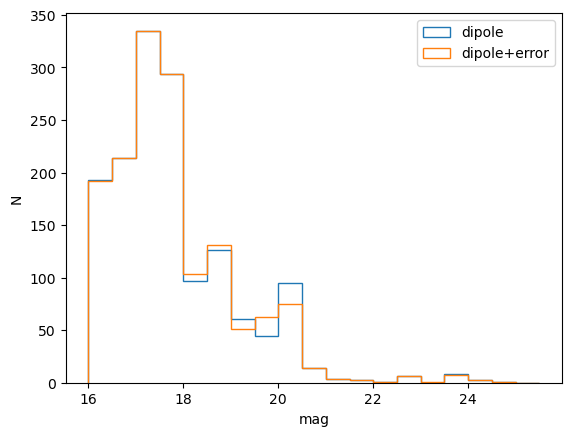

In [15]:
plt.hist(dipolemag.value, bins=np.arange(16, 26, 0.5), histtype='step', label='dipole')
plt.hist(dipolemag.value+dipolemag_err.value, bins=np.arange(16, 26, 0.5), histtype='step', label='dipole+error')
plt.xlabel('mag')
plt.ylabel('N')
plt.legend()
plt.show()

## Results

We see that the magnitudes are in the expected range of 17 < mag < 28 (for both the Object and DiaSource tables), so it's likely that the units in the table are in fact nJy. We have thus confirmed that the tables available with DP1 contain calibrated fluxes in nJy, so the result of this test is a **Pass**.
